# Directed Acyclic Graphs

My own reworking of the example code within the text book.

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

## Collider bias and "bad controls"

### Here we are running regression simulations on the below DAG included within the book.

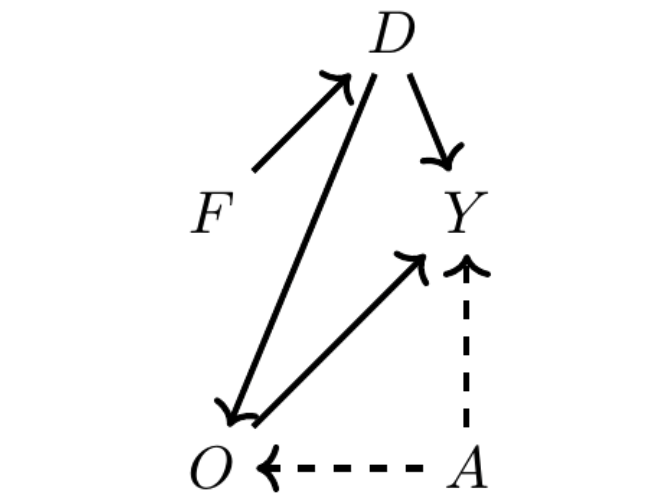

- $D =$ discrimination
- $F =$ female
- $Y =$ wages
- $O =$ occupation
- $A =$ ability (unobserved)
 

In [8]:
# We generate data here based on the above data and explicity code a negative causal
# effect of discrimination on indivdual wages

population_size = 10_000

df = pd.DataFrame()

df['female'] = np.random.binomial(
    n=1,
    p=.5,
    size=population_size
)
df['ability'] = np.random.normal(
    loc=0,
    scale=1,
    size=population_size
)

# Here is where we *hardcode* the negative causal effect of
# discrimination on wages individual wage
df['discrimination'] = df['female'].copy()
df['occupation'] = 1 + 2*df['ability'] + 0*df['female'] - 2*df['discrimination'] + np.random.normal(size=population_size)
df['wage'] = 1 - 1*df['discrimination'] + 1*df['occupation'] + 2*df['ability'] + np.random.normal(size=population_size)

In [9]:
df.head()

,female,ability,discrimination,occupation,wage
0,0,0.966954,0,1.180218,4.597755
1,0,-2.350762,0,-3.776154,-7.005575
2,0,-0.761701,0,1.265285,1.475405
3,1,-0.243859,1,-0.509408,0.559232
4,0,-1.639181,0,-1.581997,-5.095303


In [10]:
lm1 = sm.OLS.from_formula("wage ~ female", data=df).fit()
lm2 = sm.OLS.from_formula("wage ~ female + occupation", data=df).fit()
lm3 = sm.OLS.from_formula("wage ~ female + occupation + ability", data=df).fit()

### In the first simulation, we regress `wage` onto `female` and see a strong negative relationship. This is the combination of the direct effect of `discrimination` on `wage` and the indirect effect of `discrimination` on `occupation` which affects `wage`.

In [11]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1208.
Date:                Mon, 30 May 2022   Prob (F-statistic):          5.80e-250
Time:                        11:31:04   Log-Likelihood:                -28638.
No. Observations:               10000   AIC:                         5.728e+04
Df Residuals:                    9998   BIC:                         5.729e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0280      0.060     33.817      0.000       1.910       2.146
female        -2.9484      0.085    -34.755      0.000      -3.115      -2.782
==============================================================================
Omnibus:                        1.199   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.549   Jarque-Bera (JB):                1.191
Skew:                           0.027   Prob(JB):                        0.551
Kurtosis:                       3.003   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### In the second simuilation, we regress `wage` onto `female` and `occupation`. This is controlling for the following collider bias, $D \rightarrow O \leftarrow A \rightarrow Y$, which creates a spurious correlation. We can see that now the negative relationship between discrimination and wages which we coded into the model is incorrect and the relationship is flipped!

In [12]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 5.030e+04
Date:                Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                        11:31:05   Log-Likelihood:                -17190.
No. Observations:               10000   AIC:                         3.439e+04
Df Residuals:                    9997   BIC:                         3.441e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2123      0.020     10.597      0.000       0.173       0.252
female         0.5810      0.029     19.701      0.000       0.523       0.639
occupation     1.7956      0.006    297.796      0.000       1.784       1.807
==============================================================================
Omnibus:                        0.039   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.981   Jarque-Bera (JB):                0.028
Skew:                           0.002   Prob(JB):                        0.986
Kurtosis:                       3.006   Cond. No.                         6.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### In the third simuilation, we regress `wage` onto `female`, `occupation`, and `ability`. This allows us to close the backdoor pathway that includes the collider bias mentioned above. Now we can see the proper effect (which has a coefficient of approximately -1, as dicated by the model above).

In [13]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 6.334e+04
Date:                Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                        11:31:07   Log-Likelihood:                -14227.
No. Observations:               10000   AIC:                         2.846e+04
Df Residuals:                    9996   BIC:                         2.849e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0229      0.017     58.733      0.000       0.989       1.057
female        -1.0363      0.028    -36.535      0.000      -1.092      -0.981
occupation     0.9849      0.010     97.793      0.000       0.965       1.005
ability        2.0312      0.023     89.900      0.000       1.987       2.076
==============================================================================
Omnibus:                        1.545   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.462   Jarque-Bera (JB):                1.574
Skew:                           0.028   Prob(JB):                        0.455
Kurtosis:                       2.973   Cond. No.                         9.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Collider bias sampling issues

Here we are looking at the relationship between _beauty_ and _talent_ and how, if you wanted to study this relationship in the **general population**, sampling on movie stars would introduce a collider bias. For example, you could imagine that there is a simple DAG, like that below...

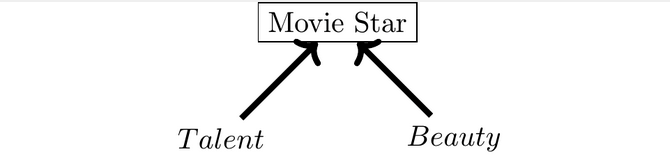

... which essentially says that being a movie star is a result of being talented or being beautiful (and assumes these are independent of one another).

Lets generate some data to represent the problem and see how trying to study the relationship between these two variables in the **general population** by using only this sample would create a collider bias.

In [78]:
# Create data with a random normal distribution of beauty and talent
df = pd.DataFrame({
    'beauty' : np.random.normal(size = population_size),
    'talent' : np.random.normal(size = population_size),
})

# We give someone a nonsense "score" value which is the sum of beauty and talent
df['score'] = df['beauty'] + df['talent']

# Then select only the top 15% of people based on this variable to represent our stars,
# capturing the rare/selective nature of becoming a movie star
df['star'] = df['score'] >= np.percentile(df['score'], q=85)


In [79]:
# Allows for plotting > 5000 data points
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [80]:
alt.Chart(df).mark_point().encode(
    x = alt.X("talent:Q"),
    y = alt.Y("beauty:Q"),
    color = alt.Color(
        "star:N", 
        scale = alt.Scale(     # manually set the colors for each value
            domain=[True,False],
            range=['red','black']
        )
    ),
).properties(width=600,height=600)

alt.Chart(...)

As you can see above, by sampling from the non-general population of _only_ movie stars, you introduce a spurious correlation between `beauty` and `talent` that is not represented in the larger population. This is derived from the collider bias detailed above.

What this (contrived) data shows us is that there is a negative relationship between `beauty` and `talent` ***given*** that you are a movie star.